# Exercise 3
---

## Part 1: Low-dimensionality reduction using PCA
1. Using STL-10 10k unlabeled dataset, build a PCA with the minimum dimensionality and best reconstruction quality
2. Plot $MSE$ vs $z-dim$. Mean squared error for the entire test set vs $z$-code dimensionality. Try the following dims: $\{32, 64, 256, 512, 1028, 2046, 4098\}$

## Part 2: Using the “optimal” $z$−dim⁡ in PCA
1. Can we fit a 10-component GMM on the unlabeled dataset $z$ code vectors from PCA?
2. Can we use the GMM and labeled train set to assign labels to the 10 clusters in GMM?
3. Report the accuracy on the test dataset.
4. Can we build an STL generative model using unlabeled dataset  PCA 𝒛 code vectors and GMM? 

# Solution
---

## Part 1

In [1]:
import sys
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from skimage.transform import resize
# import tensorflow as tf
import time

if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

print(sys.version_info) 

sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


Download STL-10 dataset. Below is a script. Reference link for the dataset is commented in the succeeding cell.

In [2]:
# script from Stanford
# https://cs.stanford.edu/~acoates/stl10/
# https://github.com/mttk/STL10

# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

  
download_and_extract()

In [3]:
# with open(UNLABELED_PATH, 'rb') as f:
DATA_PATH = './data/stl10_binary/train_X.bin'
LABEL_PATH = './data/stl10_binary/train_y.bin'
UNLABELED_PATH = './data/stl10_binary/unlabeled_X.bin'   

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

SAMPLES = 10000

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH
COUNT = SAMPLES * SIZE

# dataset = np.fromfile(UNLABELED_PATH, dtype='uint8')
dataset = np.fromfile(UNLABELED_PATH, dtype='uint8', count=COUNT)
images = np.reshape(dataset, (-1, 3, 96, 96 ))

test_images = np.fromfile('./data/stl10_binary/test_X.bin', dtype='uint8', count=COUNT)
test_images = np.reshape(test_images, (-1, 3, 96, 96 ))

In [4]:
# RGB PLOT

def plot_images(images, title, n_images=9):
    plt.figure(figsize=(10,10))
    plt.suptitle(title, fontsize=20)
    side = int(np.sqrt(n_images))
    for i in range(n_images):
        plt.subplot(side, side, i + 1)
        image = images[i, :, :,]
        image = np.transpose(image, (1, 0, 2)) # so matplotlib can plot properly
        plt.imshow(image)
        plt.axis('off')

    plt.show()

### Implement PCA Algorithm

#### Mean subtraction: 
\begin{equation*}
\textbf{ x }_{n} = \textbf{x}_{n} - \mu
\end{equation*}

#### Divide by standard deviation: 
\begin{equation*}
\textbf{ x }_{n} = \textbf{x}_{n} / \sigma
\end{equation*}

#### Formulate data matrix and covariance matrix:
\begin{equation}
\textbf{X} = [ \textbf{x}_1, ..., \textbf{x}_n ]
\end{equation}

\begin{equation}
\textbf{S} = \frac{1}{N}\textbf{XX}^T
\end{equation}

#### and perform Eigendecomposition: 
\begin{equation}
\textbf{S}=\textbf{B}\textbf{D}\textbf{B}^{-1}
\end{equation}

In [5]:
def manual_PCA(images, n_images):
  # if dim:
  #   images = resize_images(images, dim)

  images = np.float32(images)
  mu = np.mean(images)
  images -= mu

  std = np.std(images)
  images /= std

  print("Before mean: {0}, std: {1}".format(mu,std))
  mu1 = np.mean(images)
  std1 = np.std(images)
  print("After mean: {0}, std: {1}".format(mu1,std1))

  X = np.reshape(images,(-1,n_images))
  S = np.matmul(X, np.transpose(X))/n_images
  #D,B = la.eig(S,left=True,right=True)
  D,B = la.eig(S,left=True,right=False)
  

  print('X.shape: {0}'.format(X.shape))
  print('S.shape: {0}'.format(S.shape))
  print(B.shape)
  print(D.shape)

  return B, std, mu

### To reconstruct,

#### Projection or Low-Rank Approximation of $\textbf{X}$:

\begin{equation}
\textbf{R} = \textbf{B}_{M}\textbf{B}^{T}_{M}\textbf{X}
\end{equation}

#### then Backproject,
\begin{equation*}
\textbf{ x }_{n} = \textbf{x}_{n}\sigma + \mu
\end{equation*}

In [6]:
def reconstruct_from_pca(B, M, images, std, mu, recon_train=False):
  
  
  BM = B[:,:M]
  X = images
  BM_BMT = np.matmul(BM,np.transpose(BM))
  X = np.float32(np.reshape(X,(-1,X.shape[0])))
  R = np.matmul(BM_BMT,X)
  R = np.reshape(R, images.shape)
  # print(R.shape)
  if recon_train:
    R *= std
    R += mu
  R = np.clip(R, 0, 255)
  # mu1 = np.mean(R)
  # std1 = np.std(R)

  return R

The original dimensions of the dataset is $(96 \times 96 \times 3)$, but due to resource constraints, we shall downscale these images tot $(48 \times 48 \times 3)$. We shall define two functions here

In [7]:
normalize = True
if normalize:
    images = np.float32(images) / 255.
    test_images = np.float32(test_images) / 255.

# images_red = images[:,0,:,:]
# images_green = images[:,1,:,:]
# images_blue = images[:,2,:,:]

print(images.shape) # (SAMPLES, 3, 96, 96)

# test_images = images[:8000]

images = images[:,:,::2,::2]
test_images = test_images[:,:,::2,::2]

print(images.shape)
print(test_images.shape)

(10000, 3, 96, 96)
(10000, 3, 48, 48)
(8000, 3, 48, 48)


Test on following $z$-dimensions. $\{32, 64, 256, 512, 1028, 2046, 4098\}$ Since we are dealing with an RGB image, we can follow this workflow for optimal computation.

1. Separate image per channel. Essentially having 6 matrices. Three each for the unlabeled and test dataset.
2. Apply PCA algorithm per channel.
3. Save $\mu$ and $\sigma$ per channel.
4. Reconstruct **test** dataset using saved $\mu$ and $\sigma$ from fitting the unlabeled dataset earlier. Do this in a per-chanell fashion.
5. Stack the R, G, and B channels per z-dim for plotting and qualitative comparison later on.

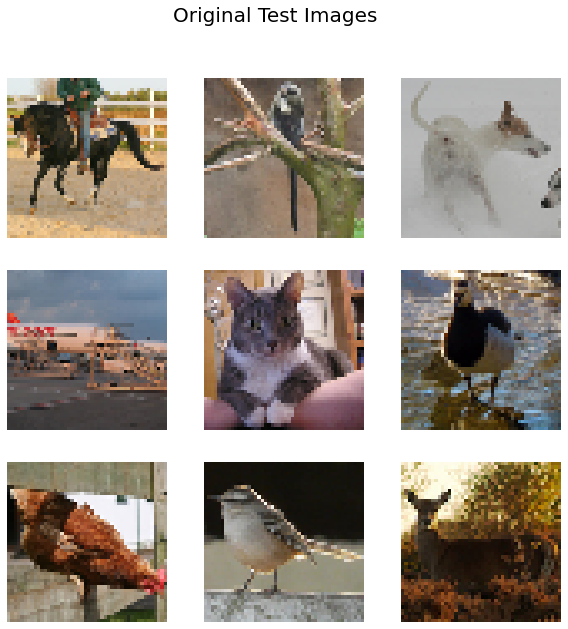

Before mean: 0.4400869309902191, std: 0.26839306950569153
After mean: -3.514464651743765e-06, std: 1.0000001192092896
X.shape: (2304, 10000)
S.shape: (2304, 2304)
(2304, 2304)
(2304,)
red done
Time elapsed for Single Channel PCA :  0.0906688928604126
Before mean: 0.4289826452732086, std: 0.2613324224948883
After mean: 2.192497277064831e-06, std: 1.0000001192092896
X.shape: (2304, 10000)
S.shape: (2304, 2304)
(2304, 2304)
(2304,)
green done
Before mean: 0.38924089074134827, std: 0.2692567706108093
After mean: 3.216425454866112e-07, std: 0.9999985694885254
X.shape: (2304, 10000)
S.shape: (2304, 2304)
(2304, 2304)
(2304,)
blue done
PCA, DIM = 32
recon done
0.012408002217610677
Computing MSE on Test


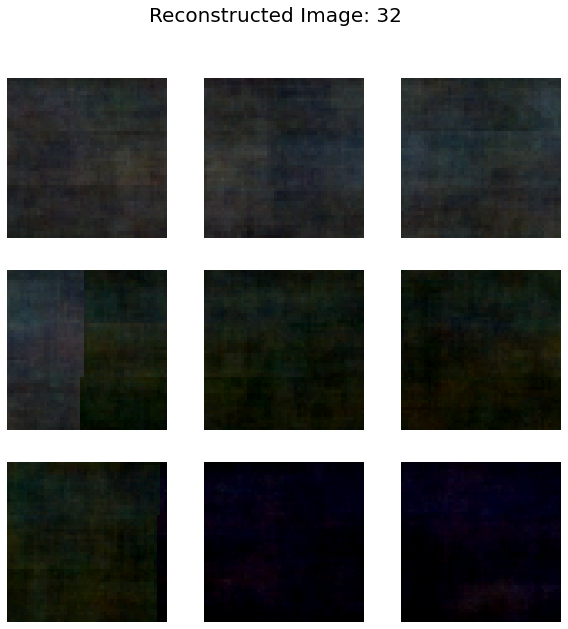

PCA, DIM = 64
recon done
0.013023483753204345
Computing MSE on Test


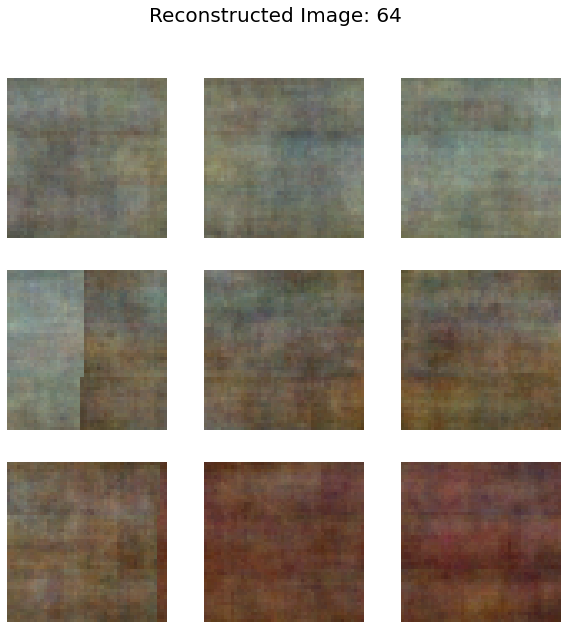

PCA, DIM = 256
recon done
0.012695840994517009
Computing MSE on Test


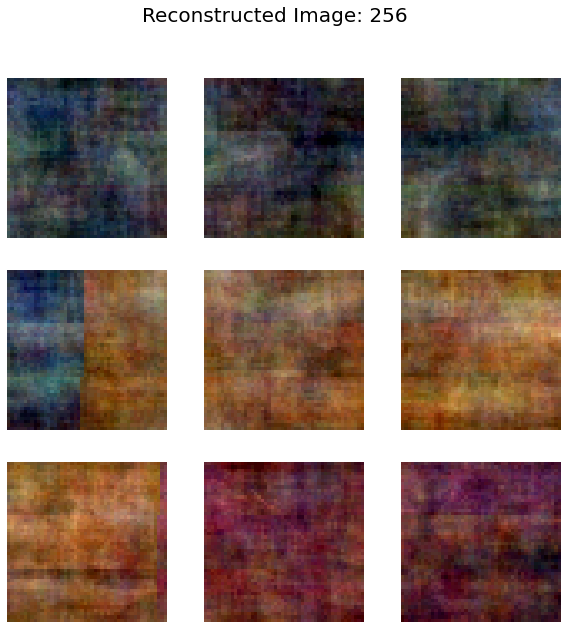

PCA, DIM = 512
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
recon done
0.013983011245727539
Computing MSE on Test


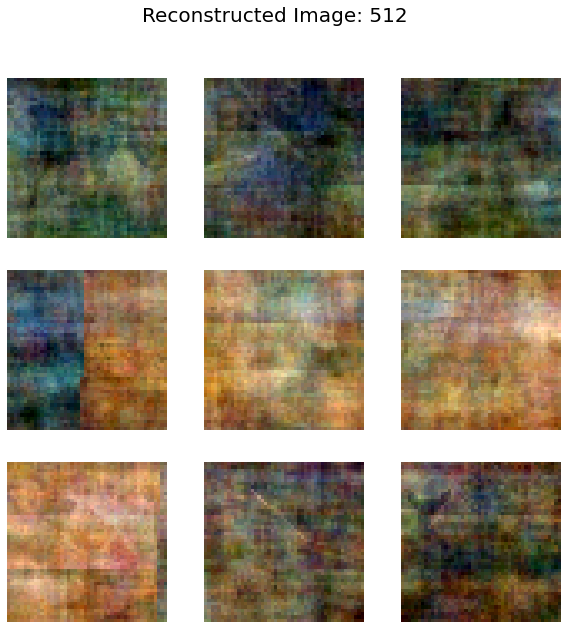

PCA, DIM = 1028
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
recon done
0.014163025220235189
Computing MSE on Test
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


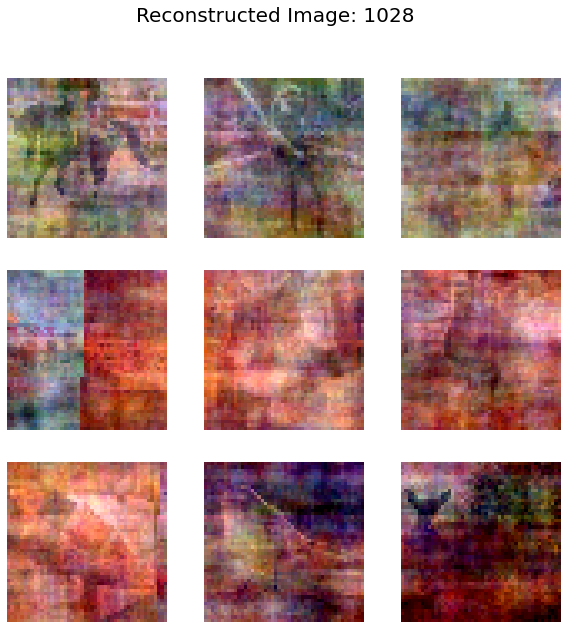

PCA, DIM = 2046
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
recon done
0.015041542053222657
Computing MSE on Test


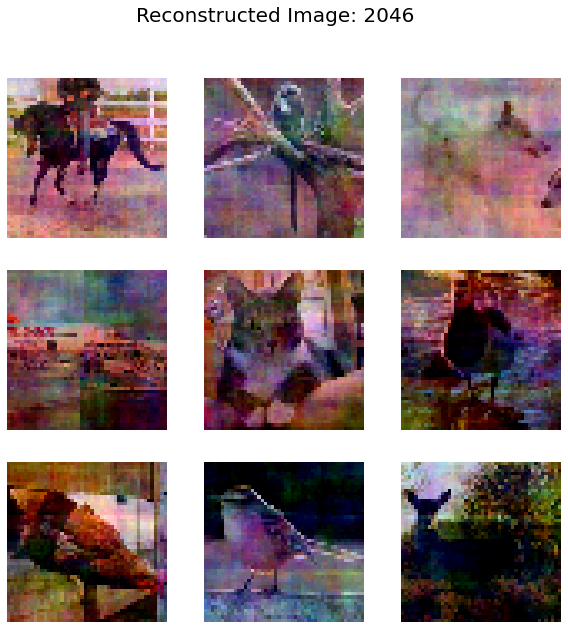

PCA, DIM = 4098
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
recon done
0.015413884321848552
Computing MSE on Test


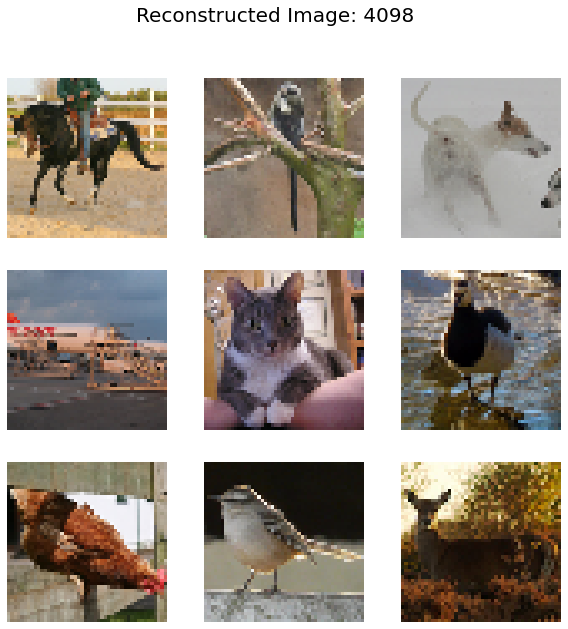

In [8]:
# dims = [32, 64, 256, 512, 1028, 2046, 4098, 5126, 6154, 7182, 8210, 9216]
dims = [32, 64, 256, 512, 1028, 2046, 4098]

def mse_vs_dim(dims, images, samples, test_images=test_images):
  mse_per_dim = []
  comparison_images = []
  comparison_images_train = []
  DIM = 48

  test_images_red = test_images.copy()[:,0,:,:]
  test_images_green = test_images.copy()[:,1,:,:]
  test_images_blue = test_images.copy()[:,2,:,:]

  rgb_test = np.zeros((8000,DIM,DIM,3), 'float32')

  rgb_test[...,0] = test_images_red
  rgb_test[...,1] = test_images_green
  rgb_test[...,2] = test_images_blue

  images_red = images.copy()[:,0,:,:]
  images_green = images.copy()[:,1,:,:]
  images_blue = images.copy()[:,2,:,:]

  # rgb_orig = np.zeros((samples,DIM,DIM,3), 'float32')
  # rgb_orig[...,0] = images_red
  # rgb_orig[...,1] = images_green
  # rgb_orig[...,2] = images_blue 

  title = "Original Test Images"
  plot_images(rgb_test, title=title)

  start = time.time()
  r_pca, std_r, mu_r = manual_PCA(images_red, n_images=samples)
  end = time.time()
  print('red done')
  print('Time elapsed for Single Channel PCA : ', (end - start)/60)
  g_pca, std_g, mu_g = manual_PCA(images_green, n_images=samples)
  print('green done')
  b_pca, std_b, mu_b = manual_PCA(images_blue, n_images=samples)
  print('blue done')

  for i in dims:
    print('PCA, DIM =', i)
    start = time.time()

    r = reconstruct_from_pca(r_pca, i, test_images_red, std_r, mu_r)
    g = reconstruct_from_pca(g_pca, i, test_images_green, std_g, mu_g)
    b = reconstruct_from_pca(b_pca, i, test_images_blue, std_b, mu_b)

    rgb_recon = np.zeros((8000,DIM,DIM,3), 'float32')
    rgb_recon[...,0] = r
    rgb_recon[...,1] = g
    rgb_recon[...,2] = b

    end = time.time()
    print('recon done')
    print((end - start)/60)

    print('Computing MSE on Test')
    mse = np.float32(np.square(np.subtract(rgb_test, rgb_recon)).mean())
    mse_per_dim = np.append(mse_per_dim, mse)

    title = "Reconstructed Image: " + str(i) 
    plot_images(rgb_recon, title=title)
    comparison_images = np.append(comparison_images, rgb_recon[4])

    r = reconstruct_from_pca(r_pca, i, images_red, std_r, mu_r, recon_train=True)
    g = reconstruct_from_pca(g_pca, i, images_green, std_g, mu_g, recon_train=True)
    b = reconstruct_from_pca(b_pca, i, images_blue, std_b, mu_b, recon_train=True)
    rgb_recon = np.zeros((10000,DIM,DIM,3), 'float32')
    rgb_recon[...,0] = r
    rgb_recon[...,1] = g
    rgb_recon[...,2] = b
    comparison_images_train = np.append(comparison_images_train, rgb_recon[0])


  return mse_per_dim, comparison_images, comparison_images_train

mse_per_dim, comparison_images, comparison_images_train = mse_vs_dim(dims=dims, images=images, samples=SAMPLES, test_images=test_images)

We then plot MSE vs $z$ dim on PCA applied on test images.

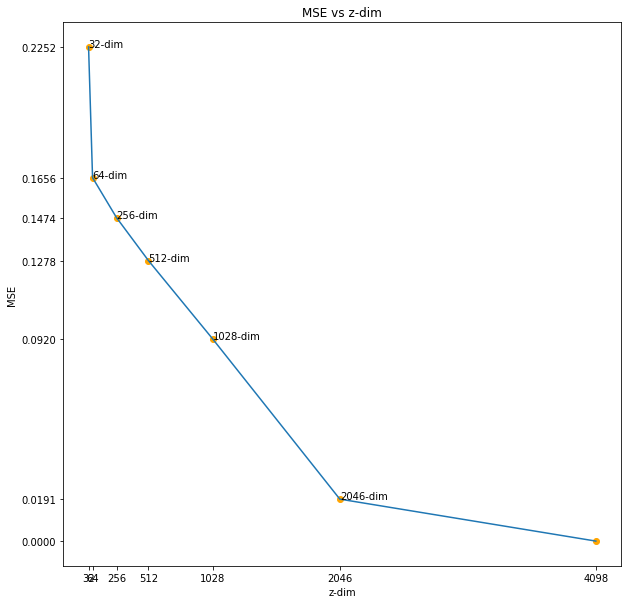

In [9]:
fig, ax = plt.subplots()
for i, txt in enumerate(dims[:6]):
    ax.annotate('%d-dim' % txt , (dims[i], mse_per_dim[i]))

fig.set_size_inches(10,10)
plt.plot(dims, mse_per_dim)
plt.scatter(dims, mse_per_dim, color='orange')
ax.set_xticks(dims)
ax.set_yticks(mse_per_dim)
plt.title('MSE vs z-dim')
plt.xlabel('z-dim')
plt.ylabel('MSE')
plt.show()

For qualitative comparison, we plot the images per $z$ dimension.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


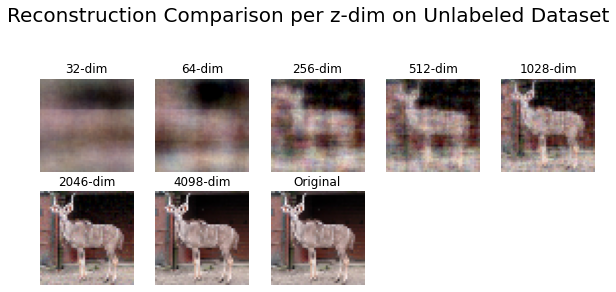

In [10]:
comparison_images_train = np.reshape(comparison_images_train,(-1,48,48,3))
comparison_images_train = np.append(comparison_images_train,np.transpose(images[0],(1,2,0)))

comparison_images_train = comparison_images_train.reshape(-1,48,48,3)

plt.figure(figsize=(10,10))
plt.suptitle('Reconstruction Comparison per z-dim on Unlabeled Dataset', fontsize=20)
side = 5
for i in range(8):
    plt.subplot(side, side, i + 1)
    image = comparison_images_train[i, :, :,]
    image = np.transpose(image, (1, 0, 2)) # so matplotlib can plot properly
    if(i==7):
        plt.title('Original')
    else:
        plt.title('%d-dim' % dims[i])
    plt.imshow(image)
    plt.axis('off')

plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


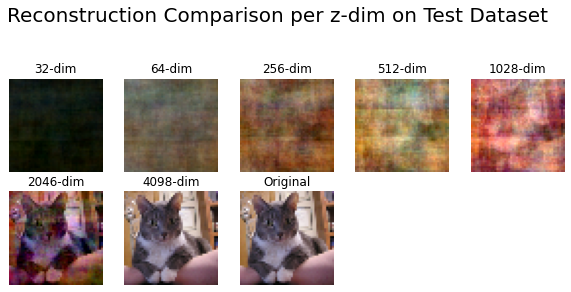

In [11]:
comparison_images = np.reshape(comparison_images,(-1,48,48,3))
comparison_images = np.append(comparison_images,np.transpose(test_images[4],(1,2,0)))

comparison_images = comparison_images.reshape(-1,48,48,3)

plt.figure(figsize=(10,10))
plt.suptitle('Reconstruction Comparison per z-dim on Test Dataset', fontsize=20)
side = 5
for i in range(8):
    plt.subplot(side, side, i + 1)
    image = comparison_images[i, :, :,]
    image = np.transpose(image, (1, 0, 2)) # so matplotlib can plot properly
    if(i==7):
        plt.title('Original')
    else:
        plt.title('%d-dim' % dims[i])
    plt.imshow(image)
    plt.axis('off')

plt.show()

#### Notice that at 4098-dim we basically fully reconstructed the original images. That is because we downsized the image by half having just 48*48 = 2304 components per channel and 4098 is way above it.

## Part 2

In Gaussian mixture models, density of the data is described as

$$
p(\boldsymbol x) = \sum_{k=1}^K \pi_k \mathcal{N}(\boldsymbol x|\boldsymbol \mu_k, \boldsymbol \Sigma_k)\,,\quad \pi_k \geq 0\,,\quad \sum_{k=1}^K\pi_k = 1
$$

Responsibilities (which are updated in the E-step), given the model parameters $\pi_k, \boldsymbol\mu_k, \boldsymbol\Sigma_k$, is defined as
$$
r_{nk} := \frac{\pi_k\mathcal N(\boldsymbol
          x_n|\boldsymbol\mu_k,\boldsymbol\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\boldsymbol
          x_n|\boldsymbol \mu_j,\boldsymbol\Sigma_j)} 
$$

Updating the model parameters in the M-step can be done as follows:
\begin{align*}
\boldsymbol\mu_k^\text{new} &= \frac{1}{N_k}\sum_{n = 1}^Nr_{nk}\boldsymbol x_n\,,\\
   \boldsymbol\Sigma_k^\text{new}&= \frac{1}{N_k}\sum_{n=1}^Nr_{nk}(\boldsymbol x_n-\boldsymbol\mu_k)(\boldsymbol x_n-\boldsymbol\mu_k)^\top\,,\\
   \pi_k^\text{new} &= \frac{N_k}{N}
\end{align*}
where

$$
N_k := \sum_{n=1}^N r_{nk}
$$

In [12]:
images_red = images.copy()[:,0,:,:]
images_green = images.copy()[:,1,:,:]
images_blue = images.copy()[:,2,:,:]

In [13]:
SAMPLES = images.shape[0]
r_pca, std_r, mu_r = manual_PCA(images_red, n_images=SAMPLES)
g_pca, std_g, mu_g = manual_PCA(images_green, n_images=SAMPLES)
b_pca, std_b, mu_b = manual_PCA(images_blue, n_images=SAMPLES)

Before mean: 0.4400869309902191, std: 0.26839306950569153
After mean: -3.514464651743765e-06, std: 1.0000001192092896
X.shape: (2304, 10000)
S.shape: (2304, 2304)
(2304, 2304)
(2304,)
Before mean: 0.4289826452732086, std: 0.2613324224948883
After mean: 2.192497277064831e-06, std: 1.0000001192092896
X.shape: (2304, 10000)
S.shape: (2304, 2304)
(2304, 2304)
(2304,)
Before mean: 0.38924089074134827, std: 0.2692567706108093
After mean: 3.216425454866112e-07, std: 0.9999985694885254
X.shape: (2304, 10000)
S.shape: (2304, 2304)
(2304, 2304)
(2304,)


In [14]:
M = 4096

B_r  = r_pca
BM_r = B_r[:,:M]
B_g  = g_pca
BM_g = B_g[:,:M]
B_b  = b_pca
BM_b = B_b[:,:M]


In [15]:
# print(B.shape)
# print(BM.shape)
# print(X.shape)
# print(np.matmul(BM.T,X).shape)

z_code_r = np.matmul(BM_r.T,np.float32(np.reshape(images_red,(-1,images_red.shape[0]))))
z_code_g = np.matmul(BM_g.T,np.float32(np.reshape(images_green,(-1,images_red.shape[0]))))
z_code_b = np.matmul(BM_b.T,np.float32(np.reshape(images_blue,(-1,images_red.shape[0]))))

In [16]:
from sklearn import mixture
from scipy.stats import multivariate_normal
import scipy.linalg as la

In [17]:
clf_r = mixture.GaussianMixture(10, covariance_type='full', random_state=0)
clf_g = mixture.GaussianMixture(10, covariance_type='full', random_state=0)
clf_b = mixture.GaussianMixture(10, covariance_type='full', random_state=0)

clf_r.fit(z_code_r.T)
print(clf_r.converged_)

clf_g.fit(z_code_g.T)
print(clf_g.converged_)

clf_b.fit(z_code_b.T)
print(clf_b.converged_)

True
True
True


In [18]:
GEN_SAMPLES = 100


gmm_generated_r, _ = clf_r.sample(GEN_SAMPLES)
gmm_generated_g, _ = clf_g.sample(GEN_SAMPLES)
gmm_generated_b, _ = clf_b.sample(GEN_SAMPLES)

In [20]:
DIM_REGEN = 48

BM_BMT = np.matmul(r_pca,np.transpose(r_pca))
R = np.matmul(BM_BMT,gmm_generated_r.T)
R_r = np.reshape(R, (-1,DIM_REGEN,DIM_REGEN))

BM_BMT = np.matmul(g_pca,np.transpose(g_pca))
R = np.matmul(BM_BMT,gmm_generated_g.T)
R_g = np.reshape(R, (-1,DIM_REGEN,DIM_REGEN))

BM_BMT = np.matmul(b_pca,np.transpose(g_pca))
R = np.matmul(BM_BMT,gmm_generated_b.T)
R_b = np.reshape(R, (-1,DIM_REGEN,DIM_REGEN))

In [21]:
rgb_recon = np.zeros((GEN_SAMPLES,DIM_REGEN,DIM_REGEN,3), 'float32')
rgb_recon[...,0] = R_r
rgb_recon[...,1] = R_g
rgb_recon[...,2] = R_b

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


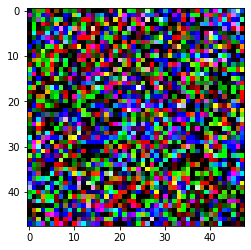

In [22]:
plt.imshow(rgb_recon[20])

Above is sklearn baseline. Below is numpy implementation.

In [25]:
K = 10 # number of clusters
n_dim = 2304

means = np.zeros((K,n_dim))
covs = np.zeros((K,n_dim,n_dim))
for k in range(K):
    means[k] = np.random.normal(size=(n_dim,))
    covs[k] = np.eye(n_dim)

weights = np.ones((K,1))/K
print("Initial mean vectors (one per row):\n" + str(means))
print(covs)

Initial mean vectors (one per row):
[[ 0.77675122  1.20146847 -0.2317047  ... -1.2113695  -0.47857176
   0.50181354]
 [-1.18024794  0.73990875  2.48795028 ...  0.92285965 -0.49751926
  -0.16594723]
 [-0.26220819 -0.40779148  0.9671857  ...  0.27093616  1.92937776
  -0.38123205]
 ...
 [ 0.57535089 -1.27623893 -0.58843    ... -0.06576846  0.09743772
   0.03735658]
 [ 0.28245317 -1.47415037  0.4651101  ... -2.17554469  0.69210162
  -0.9406195 ]
 [-0.86587336  0.87573786  1.86734511 ...  1.28224718  0.0864947
  -1.36825338]]
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 

In [26]:
data = z_code_r
# data = z_code_g
# data = z_code_b

#EDIT THIS FUNCTION
NLL = [] # log-likelihood of the GMM
gmm_nll = 0
for k in range(K):
    gmm_nll += weights[k]*multivariate_normal.pdf(mean=means[k,:], cov=covs[k,:,:], x=data.T)
NLL += [-np.sum(np.log(gmm_nll))]


for k in range(K):
    rv = multivariate_normal(means[k,:], covs[k,:,:])

In [ ]:
N = 10000

#EDIT THIS FUNCTION
r = np.zeros((K,N)) # will store the responsibilities

for em_iter in range(1):    
    means_old = means.copy()
    
    # E-step: update responsibilities
    for k in range(K):
        r[k] = weights[k]*multivariate_normal.pdf(mean=means[k,:].ravel(), cov=covs[k,:,:], x=data.T)  
        
    r = r/np.sum(r, axis=0) 
        
    # M-step
    N_k = np.sum(r, axis=1)

    for k in range(K): 
        # update means
        means[k] = np.sum(r[k]*data, axis=1)/N_k[k]
        
        # update covariances
        diff = data - means[k:k+1].T
        _tmp = np.sqrt(r[k:k+1])*diff
        covs[k] = np.inner(_tmp, _tmp)/N_k[k]
        
    # weights
    weights = N_k/N 
    
    # log-likelihood
    gmm_nll = 0
    for k in range(K):
        gmm_nll += weights[k]*multivariate_normal.pdf(mean=means[k,:].ravel(), cov=covs[k,:,:], x=data.T)
    NLL += [-np.sum(np.log(gmm_nll))]
    
    for k in range(K):
        rv = multivariate_normal(means[k,:], covs[k])
    
    if la.norm(NLL[em_iter+1]-NLL[em_iter]) < 1e-6:
        print("Converged after iteration ", em_iter+1)
        break
   
gmm = 0
for k in range(K):
    mix_comp = multivariate_normal(means[k,:].ravel(), covs[k,:,:])
    gmm += weights[k]*mix_comp.pdf(pos)
